# imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#!rm -r /home/jovyan/.local/share/jupyter/kernels/nilmtk
!pip uninstall -y -q nilmtk nilm_metadata
#!pip install -q pandas networkx tables scikit-learn hmmlearn pyyaml matplotlib==3.1.3 xgboost pyts
# Trick to install NILM regardless of its dependencies
#!pip install --no-cache -U git+https://github.com/nilmtk/nilm_metadata.git
#!pip install --no-cache -U git+https://github.com/nilmtk/nilmtk.git@0.4.3
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilmtk@master
!python3 -m pip install --no-deps git+https://github.com/nilmtk/nilm_metadata@master

  Cloning https://github.com/nilmtk/nilmtk (to revision master) to /tmp/pip-req-build-zsajp_k0
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilmtk /tmp/pip-req-build-zsajp_k0
  Resolved https://github.com/nilmtk/nilmtk to commit dde510b7b2299958597a6b3885230844c1b7e9da
  Preparing metadata (setup.py) ... done
  Created wheel for nilmtk: filename=nilmtk-0.4.0.dev1+git.dde510b-py3-none-any.whl size=279053 sha256=2ca46938fd58bd157da08a41f5098a58cedaa38f5fd9c987e6865e1f86ee6fbb
  Stored in directory: /tmp/pip-ephem-wheel-cache-r_i7_v_f/wheels/05/a4/8e/b767c3d1714f61fd30ec991c25780be8cc04c474da8205aeee
Successfully built nilmtk
  Cloning https://github.com/nilmtk/nilm_metadata (to revision master) to /tmp/pip-req-build-gebv7dqg
  Running command git clone --filter=blob:none --quiet https://github.com/nilmtk/nilm_metadata /tmp/pip-req-build-gebv7dqg
  Resolved https://github.com/nilmtk/nilm_metadata to commit 7ed4bab9062d04cb35c6b6000b451715dc5ab4af
  Prep

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!mamba install tensorflow-gpu==2.10 -y -q

!pip3 install tensorflow

from nilmtk import DataSet
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from joblib import Memory
import pickle
from pprint import pprint

#from nilmtk import DataSet
import multiprocessing as mp

from typing import Dict

!pip install -q scikit-learn-intelex
#from sklearnex import patch_sklearn
#patch_sklearn()

from sklearn import pipeline, metrics, linear_model, model_selection, multioutput, tree, ensemble, neural_network
!pip install xgboost
import xgboost as xgb

import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split

import numpy as np
#import graphviz
import keras
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
#from ann_visualizer.visualize import ann_viz
from matplotlib import pyplot as plt 
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix
# GPU goes brrrrrrrrrrrrrrrrrrrr
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://docs.nvidia.com/cuda/eula/index.html

By downloading and using the cuDNN conda packages, you accept the terms and conditions of the NVIDIA cuDNN EULA -
  https://docs.nvidia.com/deeplearning/cudnn/sla/index.html

done
  Using cached xgboost-1.7.5-py3-none-manylinux2014_x86_64.whl (200.3 MB)


2023-04-22 23:02:31.366214: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100 80GB PCIe MIG 3g.40gb, compute capability 8.0


In [4]:
memory = Memory(location='./cache')

# functions

In [5]:
@memory.cache
def load_refit_dataset():
    try:
        dataset = DataSet('./refit.hdf5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                assert len(meter.appliances) < 2

                # TODO: Poglej s kje jemlje sample Jakob.
                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
        
dataset = load_refit_dataset()

In [6]:
#@memory.cache

#def load_ukdale_dataset():
#    try:
#        dataset = DataSet('./ukdale.hdf5')
#
#        samples = []
#        for building_idx, building in dataset.buildings.items():
#            for meter in building.elec.all_meters():
#
#                data = list(meter.load())
#                assert len(data) == 1
#
#                #assert len(meter.appliances) < 2
#
#                # TODO: Poglej s kje jemlje sample Jakob.
#                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())
#
#                samples.append(sample)
#                
#        return samples
#
#    except Exception as e:
#        dataset.store.close()
#        raise e
#        
#dataset = load_ukdale_dataset()

In [7]:
# We initialize the table that will hold the data for all houses separately
houses = []

# We count the number of houses and make appropriate number of sublists in houses

# To do that we first make a list of all devices from houses
div_house_list = []
for i in range(len(dataset)):
    div_house_list.append(dataset[i][0])
div_house_list = sorted(div_house_list)
#print(div_house_list)

# Then we count the occurences 
occurences = []
for i in range(len(div_house_list)):
    if div_house_list.count(i) > 0: 
        occurences.append(div_house_list.count(i))
#print(occurences)

for h in range(len(occurences)):
    houses.append([])
    N = occurences[h]
#    for i in range(N):
    for j in range(len(dataset)):
        #if datasets[j][0] == i: 
        #    houses.append([dataset[i]])
        if dataset[j][0] == h+1:
            houses[h].append(dataset[j])

In [8]:
import random
import numpy
import math
from sklearn.model_selection import train_test_split
import itertools


def ListAverage(lst):
    return sum(lst)/len(lst)


def WindowCounter(house: int, window_len: int):
    
    # A function that counts the number of windows of the set length in the dataset
    
    # we initialize the list that will hold the maximal number of time windows of the chose length that can be extracted from the dataset
    lst = []
    
    # We make a for loop that goes over all devices in the house and counts the maximal number of time windows and then adds them to lst
    for i in range(len(houses[house-1])):
        # Assuming the DataFrame is stored in houseX[0][2][0]
        window = pd.Timedelta(hours=window_len)
        start_time = houses[house-1][i][2][0].index[0]
        end_time = start_time + window

        count = 0

        while end_time <= houses[house-1][i][2][0].index[-1]:
            count += 1
            start_time = end_time
            end_time = start_time + window    

        lst.append(count)
        
    # All devices should have the same number of time windows, if not, we print a warning and choose the biggest number of windows that all devices can provide
    if len(set(lst)) != 1:
        print("Devices have different numbers of time windows, the biggest possible was chosen.")
        
    return min(lst)


def class_weights_tool(y_test):
    
    # This function returns class weights for each device in a prticular dataset in a form of a dicitionary.
    # It does so by simply counting how many times the device is present througout the dataset.
    
    # inspired by ronnie coleman
    light_weight, nums = [], []
    
    # this for loop goes over the collumns of the y_test dataset
    for j in range(0,len(y_test[0])):             
        
        count=0
        
        # gives 0,1,2,3,4,5,6....
        nums.append(j)
        
        # this loop goes over the rows in the y_test dataset
        for i in range(0,len(y_test)):
            
            # we count Trues in the whole column of y_test dataset
            if y_test[i][j] == True: count+=1     
        
        # we append Trues for the column of y_test dataset to the list light_weight
        light_weight.append(count)
        
    # makes the dictionary    
    class_weights_dictionary = dict(zip(nums, light_weight))             
    
    return class_weights_dictionary


def XYDatasetGenerator(house: int, window_len: int):
    
    # We adjust house numbers to 0,1,2,3,4,... from 1,2,3,4,...
    house = house - 1
    
    # Noise floor
    NOISE_FLOOR = 20.0
    
    # We note the devices
    labels = []
    for i in range(len(houses[house])):
        device = houses[house][i][1]
        if device == []:
            print("There is a nameless device or something thats not a device in the dataset, data that belongs to it wont be in the produced dataset.")
        else: 
            labels.append(device[0])
    
    labels = tuple(labels)
        
    #print("################################# labels ###############################")
    #print(labels)
    #print("#######################################################################")
    
    # We count the windows of the selected size
    number_of_windows = WindowCounter(house+1, window_len)
    print(f"In house {house+1} there are {number_of_windows} {window_len}h long windows.")
    
    # We make a list of 3D numpy arrays of each device
    window_sum_devices_list = []
    window_sum_devices_3d = []
    list_window_array_3d = []
    for h in range(len(houses[house])):
        
        window = pd.Timedelta(hours=window_len)
        start_time = houses[house][0][2][0].index[0]
        end_time = start_time + window
        
        # Initialize an empty list to store the 2D numpy ndarrays
        window_array_list = []
        # Initialize a variable to keep track of the maximum number of samples in any 6-hour time window
        max_samples = 0
        
        for i in range(number_of_windows):
            # First we get pandas dataframe that is at the size of the window
            window_data = houses[house][h][2][0].loc[start_time:end_time]

            # We turn that dataframe into an array
            window_array = window_data.to_numpy(dtype=np.float64)

            # Find the number of samples in this 6-hour time window
            num_samples = window_array.shape[0]

            # Make a list of six_hour_arrays
            window_array_list.append(window_array)
            
            

            # Update the maximum number of samples
            max_samples = max(max_samples, num_samples)

            start_time = end_time
            end_time = start_time + window
            
        # time windows have sligthly different numbers of samples. 
        # Pad the 2D numpy ndarrays with zeros to ensure they all have the same number of samples
        for i in range(number_of_windows):
            window_array = window_array_list[i]
            num_samples = window_array.shape[0]
            if num_samples < max_samples:
                num_missing_samples = max_samples - num_samples
                zeros_array = np.zeros((num_missing_samples, window_array.shape[1]), dtype=np.float64)
                window_array_list[i] = np.vstack((window_array, zeros_array))
                
        # Shuffle the order of the 2D numpy ndarrays
        #np.random.shuffle(window_array_list)

        # Stack the 2D numpy ndarrays into a 3D numpy ndarray
        window_array_3d = np.stack(window_array_list)
        
        # Add the 3D numpy ndarray to the list
        list_window_array_3d.append(window_array_3d)
    
    #print(list_window_array_3d[1:])
    
    #print("|||||||||sum_devices|||||||||||||||||")
    #print(window_sum_devices_list[888])
    #print("|||||||||||||||||||||||||||||||||")
    
    # Shuffle the order of the 2D numpy ndarrays
    #np.random.shuffle(window_sum_devices_list)

    # Stack the 2D numpy ndarrays into a 3D numpy ndarray
    #window_sum_devices_3d = np.stack(window_sum_devices_list)
    
    #print("###############################################")
    #print(window_sum_devices_3d)
    #print("###############################################")
    
    
    
    # In order to get the signal that was the output of the whole house we must make a sum of signals that belong to individual devices
    #shelf = list_window_array_3d[1]
    #for arr in list_window_array_3d[2:]:
    #    result += arr
    window_sum_devices_3d = np.sum(list_window_array_3d[1:], axis=0)


    #print("################################# sum of devices ###############################")
    #print(window_sum_devices_3d)
    #print(window_sum_devices_3d.shape)
    #print("#######################################################################")
    
    
    # Now we have to make a mask which will give us the information on all active devices (so all devices with P > 20.0W)
    
    # We make a dummy array so that we dont change the src
    list_window_array_3d_dummy = list_window_array_3d[1:]
    
    # We initialize a list that will hold arrays of masks
    array_mask_list = []
    
    for arr in list_window_array_3d_dummy:
        
        # Check if elements are greater than 20
        mask = arr > NOISE_FLOOR
        
        # Replace the elements with 1 if they are bigger than 20 and 0 if they arent
        arr[mask] = True
        arr[~mask] = False
        
        # This code would replace it with True and False instead of 1 and 0
        #arr = np.where(mask, True, False)
        
        # Add the resultin array to a list
        array_mask_list.append(arr)

        
    # Now we have to make an array that will tell us this data for all devices at once and not just for one 
    
    # Initialize an empty list to hold the results
    list_nonzero = []

    # Loop over each 3D array
    for arr in array_mask_list:
        
        # Check if any element in each 2D array is nonzero
        arr_nonzero = np.any(arr != 0, axis=1).astype(bool)
        #arr_nonzero = np.any(arr != False, axis=1)
        
        # Append the result to the list
        list_nonzero.append(arr_nonzero)

    # Concatenate the results into a single 2D array
    window_mask_2d = np.concatenate(list_nonzero, axis=1)#.T

    
    #print("################################# array_mask_list ###############################")
    #print(window_mask_2d)
    #print(window_mask_2d.shape)
    #print("#######################################################################")
    
    
    # Now we have to randomly mix the data, but we must be careful to match the time window in window_sum_devices_3d with the devices on/off status in window_mask_2d
    
    # First we generate a random permuation of indices
    #permutation = np.random.permutation(number_of_windows)
    
    # And then we apply them to the arrays
    #window_sum_devices_3d_shuffled = window_sum_devices_3d[permutation]
    #window_mask_2d_shuffled = window_mask_2d[permutation]
    
    
    #print("################################# array_mask_list ###############################")
    #print(window_mask_2d_shuffled)
    #print(window_mask_2d_shuffled.shape)
    #print(permutation)
    #print("#######################################################################")
    
    
    # Now we just have to split the arrays into x_train, y_train, x_test, y_test
    
    # get the split index
    split_idx = int(number_of_windows * 0.8)

    # shuffle the indices
    indices = np.arange(number_of_windows)
    np.random.shuffle(indices)

    # split the indices into train and test sets
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]

    # use the indices to split the arrays
    x_train = window_sum_devices_3d[train_indices]
    x_test = window_sum_devices_3d[test_indices]
    y_train = window_mask_2d[train_indices]
    y_test = window_mask_2d[test_indices]

    # check the shapes
    print("The produced datasets have the following shapes:")
    print("x_train: ", x_train.shape)  # (1975, 3759, 1)
    print("x_test:  ", x_test.shape)   # (494, 3759, 1)
    print("y_train: ", y_train.shape)  # (1975, 9)
    print("y_test:  ", y_test.shape)   # (494, 9)
    
    
    return x_train, y_train, x_test, y_test, labels
    
    
#x_train, y_train, x_test, y_test, labels = XYDatasetGenerator(2,6)

In [40]:
import pickle

HolyDataset = pickle.load(open('HolyDataset.pkl', 'rb'))
Hx_train = HolyDataset[0]
Hx_test = HolyDataset[1]
Hy_train = HolyDataset[2]
Hy_test = HolyDataset[3]
Hlabels = HolyDataset[4]

print("############################ HolyDataset #############################")
print(len(Hx_train), len(Hx_train[0]), len(Hx_train[0][0]))
print(len(Hy_train), len(Hy_train[0]))
print(Hx_train, Hx_train[0], Hx_train[0][0], Hx_train[0][0][0])
print(type(Hx_train), type(Hx_train[0]), type(Hx_train[0][0]), type(Hx_train[0][0][0]))
print(Hy_train[6])
print(type(Hy_train), type(Hy_train[0]), type(Hy_train[0][0]))

print("############################ natural 6h window dataset #############################")
print(len(x_train), len(x_train[0]), len(x_train[0][0]))
print(len(y_train), len(y_train[0]))
print(x_train, x_train[0], x_train[0][0], x_train[0][0][0])
print(type(x_train), type(x_train[0]), type(x_train[0][0]), type(x_train[0][0][0]))
print(y_train[6])
print(type(y_train), type(y_train[0]), type(y_train[0][0]))

print("############################ labels #############################")
print(labels)
print(type(labels))
print(Hlabels)
print(type(Hlabels))

############################ HolyDataset #############################
96000 2550 1
96000 5
[[[0.000e+00]
  [0.000e+00]
  [0.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[0.000e+00]
  [0.000e+00]
  [0.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[0.000e+00]
  [1.000e+00]
  [0.000e+00]
  ...
  [2.753e+03]
  [2.811e+03]
  [2.741e+03]]

 ...

 [[0.000e+00]
  [0.000e+00]
  [0.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[0.000e+00]
  [0.000e+00]
  [0.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]

 [[0.000e+00]
  [0.000e+00]
  [0.000e+00]
  ...
  [0.000e+00]
  [0.000e+00]
  [0.000e+00]]] [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]] [0.] 0.0
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
[ True False False  True  True]
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.bool_'>
############################ natural 6h window dataset #############################
1975 3759 1
1975

In [9]:
def data_preparation(dataset):
    X = defaultdict(lambda: [])

    for (idx, appliances, data, good_sections) in dataset:
        if not appliances:
            continue
            
        appliance = appliances[0]
        data = data[0]
    
        samples = [data[good.start:good.end] for good in good_sections]
        X[appliance].extend(samples)
        
    for appliance, samples in X.items():
        print(appliance, len(samples))
        
    return X

prepared_data  = data_preparation(dataset)

fridge 2924
freezer 7470
washer dryer 1372
washing machine 12790
dish washer 9315
computer 6191
television 12041
electric space heater 2893
food processor 2875
toaster 6513
fridge freezer 9713
microwave 11100
kettle 7631
broadband router 1587
audio system 2637
unknown 2851
tumble dryer 4841
dehumidifier 968
breadmaker 475
games console 475
fan 588
appliance 285
pond pump 285


In [10]:
processed_data = {}

for appliance, samples in prepared_data.items():
    processed_samples = []
    for sample in samples:
        sample = sample.resample('7s').ffill(limit=1).fillna(0)
        
        # It should contain at least one sample
        if len(sample) < 2:
            continue
        
        # TODO: Filter < 20W (Poglej Blažev članek
        if not np.any(sample.to_numpy() > 20):
            continue
            
        processed_samples.append(sample)
        
    
    processed_data[appliance] = list(processed_samples)
    
    #processed_data[appliance] = list([s.resample('7s').ffill(limit=1).fillna(0) for s in samples])
    
processed_data.pop('unknown', None);

for k, v in processed_data.items():
    print(k, len(v))

fridge 1598
freezer 4385
washer dryer 316
washing machine 2590
dish washer 1769
computer 2893
television 5355
electric space heater 255
food processor 458
toaster 1659
fridge freezer 5415
microwave 2873
kettle 2348
broadband router 895
audio system 315
tumble dryer 739
dehumidifier 161
breadmaker 98
games console 117
fan 63
appliance 61
pond pump 75


# Models

In [15]:
import numpy as np
import warnings
import math

from keras.models import Model
from keras.layers import Flatten, Dense, Input, GRU, BatchNormalization, LSTM, Bidirectional, AveragePooling1D
from keras.layers import Conv1D, Conv1DTranspose, LocallyConnected1D, SeparableConv1D, ConvLSTM1D
from keras.layers import MaxPooling1D, Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
#from keras.applications.imagenet_utils import _obtain_input_shape
#from keras.engine.topology import get_source_inputs


#WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
#WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'


def VGG19_1D(classes,
             window_size,
             gru,
             gru_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units
    if gru == True:
        print("GRU enabled")
        x = GRU(gru_num, activation='tanh', recurrent_activation='sigmoid')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg19_1D')
    return model

def VGG11_1D(classes,
             window_size,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = MaxPooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = MaxPooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block4_pool')(x)

    # Block 5
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block5_conv2')(x)
    x = MaxPooling1D((2), strides=(2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg11_1D')
    return model


def PE2(classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Block 5
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    #x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)                
        
    if method == 'gru2':
        print("GRU enabled")
        x = GRU(method_num,activation='tanh',recurrent_activation='sigmoid',reset_after=True)(x)        
        
    if method == 'bigru':
        print("Bi-GRU enabled")
        x = Bidirectional(GRU(method_num, activation='tanh', recurrent_activation='sigmoid'))(x)
        
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='PE2')
    return model


def PEH(classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    #x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    #x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    #x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    #x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Block 5
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    #x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)                
        
    if method == 'gru2':
        print("GRU enabled")
        x = GRU(method_num,activation='tanh',recurrent_activation='sigmoid',reset_after=True)(x)        
        
    if method == 'bigru':
        print("Bi-GRU enabled")
        x = Bidirectional(GRU(method_num, activation='tanh', recurrent_activation='sigmoid'))(x)
        
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        #x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='PEH')
    return model



def PEH2(classes,
             window_size,
             method,
             method_num,
             include_top=True,
             input_tensor=None,
              pooling=None):

    # Determine proper input shape
    input_shape = (window_size,1)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    #x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    #x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Block 5
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer, btw GRU stands for Gated Recurrent Units; https://en.wikipedia.org/wiki/Gated_recurrent_unit
    if method == 'gru':
        print("GRU enabled")
        x = GRU(method_num, activation='tanh', recurrent_activation='sigmoid')(x)                
        
    if method == 'gru2':
        print("GRU enabled")
        x = GRU(method_num,activation='tanh',recurrent_activation='sigmoid',reset_after=True)(x)        
        
    if method == 'bigru':
        print("Bi-GRU enabled")
        x = Bidirectional(GRU(method_num, activation='tanh', recurrent_activation='sigmoid'))(x)
        
    if method == 'lstm':
        print("LSTM enabled")
        x = LSTM(method_num, activation='tanh', recurrent_activation='sigmoid')(x)
    
    # LSTM layer, btw LSTM stands for long short-term memory; https://en.wikipedia.org/wiki/Long_short-term_memory
    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='sigmoid', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling1D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling1D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='PEH2')
    return model

###########################################################
[0.7456211396192342, 0.6611620735206541, 0.6358714624641097, 0.7344330381572306, 0.736195133724799, 0.5691765169066363, 0.7518939431991997, 0.7885413467154524, 0.49542418455473203, 0.7861556759066064, 0.6994337118194718, 0.6856385863501462, 0.506483771826172, 0.5158184598577688, 0.755989808857763, 0.7296964249763699, 0.8747828692852048, 0.5410188789964048, 0.705186473737308, 0.5305700551079394]
0.8747828692852048
avg:  0.6724546777791602
###########################################################
[0.7669474221465153, 0.6641193813726801, 0.6278743177294137, 0.656916159513887, 0.5719201484081285, 0.5707523058051582, 0.8041792294411498, 0.8302516276540979, 0.4822246603597776, 0.8078986333342065, 0.6754920093494866, 0.7227642146543457, 0.49043371655524437, 0.546345386930049, 0.6951657410725114, 0.7281410376988887, 0.8719069879131001, 0.5439141626757907, 0.7068531496186333, 0.5612148650601582]
0.8719069879131001
avg:  0.66626575786

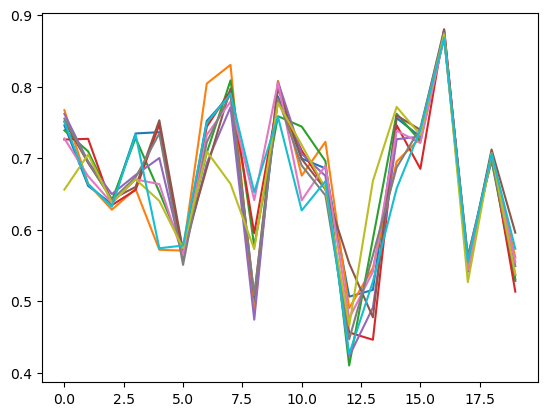

In [12]:
def avg(lst):
    return sum(lst)/len(lst)
for i in range(10):
    print("###########################################################")
    result_0 = pickle.load(open(f'./results/REFIT/PE2_{i}.pkl','rb'))
    print(result_0[7])
    plt.plot(result_0[7])
    print(result_0[7][16])
    print("avg: ", avg(result_0[7]))

# DL

In [30]:
number_of_houses = 20
time_window = 6 #set the time window in hours
epochs = 20
batch_size = 128
learning_rate = 0.0001
nm_houses_refit = 20


#def TrainingAndEvaluation(time_window, epochs, batch_size)
#    if name = 'refit':
#        nm_houses = 20
#    else: print("Write the name of the dataset in all small letter EX: 'refit'")

for j in range(10):
    
    # We write results into a table that has some data
    results = [
        ["REFIT"],
        ["number_of_houses", number_of_houses],
        ["time_window", time_window],
        ["architecture", "PE2"],
        ["epochs", epochs],
        ["batch_size", batch_size],
        ["learning_rate", learning_rate], 
        [],
        [],
        [x_train, x_test, y_train, y_test, labels],
        [y_pred_tf],
        ["repetition", j]
    ]
    
    # We go over all houses in each repetition
    for i in range(1,number_of_houses+1):
        
        print(f"################ house {i} iteration {j} ################")

        x_train, y_train, x_test, y_test, labels = XYDatasetGenerator(i,time_window)

        # |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
        model = PE2(len(y_train[0]), len(x_train[0]), 'gru', 64)
        model.build((len(y_train)+len(y_test),len(x_train[0]),1))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
        model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights_tool(y_test), verbose=0)
        
        # |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
        model.save(f'./models/REFIT/house{i}/PE2_{j}')
        
        # |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
        y_pred = model.predict(x_test, verbose=0)
        y_pred_tf = (y_pred > 0.5)
        print("||||||||||||||||||||||||||||||||| result ||||||||||||||||||||||||||||||||||||")
        print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
        print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

        results[7].append(metrics.f1_score(
            y_test, 
            y_pred_tf, 
            labels=None, 
            pos_label=1, 
            average='weighted', 
            sample_weight=None, 
            zero_division=0
        ))
        
        results[8].append(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))

    pickle.dump(results, open(f"./results/REFIT/PE2_{j}.pkl", "wb"))

################ house 1 iteration 0 ################
There is a nameless device or something thats not a device in the dataset, data that belongs to it wont be in the produced dataset.
In house 1 there are 2555 6h long windows.



KeyboardInterrupt



In [32]:
number_of_houses = 20
time_window = 6 #set the time window in hours
epochs = 20
batch_size = 128
learning_rate = 0.001
nm_houses_refit = 20
house = 15
i = house


idx = [3,6,9,12,15,18,21,24]
for hours_idx in range(5,6):
    time_window = idx[hours_idx]

    x_train, y_train, x_test, y_test, labels = XYDatasetGenerator(i,time_window)

    # |||||||||||||||||||||||||||||||| DL ||||||||||||||||||||||||||||||||
    #model = PE2(len(y_train[0]), len(x_train[0]), 'gru', 64)
    #model = PEH(len(y_train[0]), len(x_train[0]), 'gru', 64)
    #model = VGG19_1D(len(y_train[0]), len(x_train[0]), False, 0)
    model = PEH(len(y_train[0]), len(x_train[0]), 'gru', 512)
    model.build((len(y_train)+len(y_test),len(x_train[0]),1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, class_weight=class_weights_tool(y_test), verbose=1)

    # |||||||||||||||||||||||||||||||| save ||||||||||||||||||||||||||||||||
    #model.save(f'./models/REFIT/house{i}/PE2_{j}')
    model.save(f'./models/REFIT_hack/house{i}/PEH2')

    # |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
    y_pred = model.predict(x_test, verbose=1)
    y_pred_tf = (y_pred > 0.5)
    print("||||||||||||||||||||||||||||||||| result ||||||||||||||||||||||||||||||||||||")
    print(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))
    print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")

    
    results = [
        ["REFIT"],
        ["number_of_houses", number_of_houses],
        ["time_window", time_window],
        ["architecture", "PEH2"],
        ["epochs", epochs],
        ["batch_size", batch_size],
        ["learning_rate", learning_rate], 
        [],
        [],
        [x_train, x_test, y_train, y_test, labels],
        [y_pred_tf]
    ]

    
    results[7].append(metrics.f1_score(
        y_test, 
        y_pred_tf, 
        labels=None, 
        pos_label=1, 
        average='weighted', 
        sample_weight=None, 
        zero_division=0
    ))

    results[8].append(metrics.classification_report(y_test, y_pred_tf, target_names=labels, zero_division=0))

    pickle.dump(results, open(f"./results/REFIT_hack/PEH2{time_window}h.pkl", "wb"))

There is a nameless device or something thats not a device in the dataset, data that belongs to it wont be in the produced dataset.
In house 15 there are 724 18h long windows.
The produced datasets have the following shapes:
x_train:  (579, 10770, 1)
x_test:   (145, 10770, 1)
y_train:  (579, 9)
y_test:   (145, 9)
GRU enabled
Epoch 1/20
5/5 [==============================] - 2s 81ms/step - loss: 87.7568 - accuracy: 0.8238
Epoch 2/20
5/5 [==============================] - 0s 80ms/step - loss: 78.4143 - accuracy: 0.1088
Epoch 3/20
5/5 [==============================] - 0s 80ms/step - loss: 71.5697 - accuracy: 0.9965
Epoch 4/20
5/5 [==============================] - 0s 81ms/step - loss: 68.3106 - accuracy: 0.9965
Epoch 5/20
5/5 [==============================] - 0s 80ms/step - loss: 68.3277 - accuracy: 0.9965
Epoch 6/20
5/5 [==============================] - 0s 80ms/step - loss: 67.4011 - accuracy: 0.9965
Epoch 7/20
5/5 [==============================] - 0s 79ms/step - loss: 67.2869 - accu

INFO:tensorflow:Assets written to: ./models/REFIT_hack/house15/PEH2/assets


INFO:tensorflow:Assets written to: ./models/REFIT_hack/house15/PEH2/assets


5/5 [==============================] - 0s 11ms/step
||||||||||||||||||||||||||||||||| result ||||||||||||||||||||||||||||||||||||
                       precision    recall  f1-score   support

       fridge freezer       0.99      1.00      1.00       128
       fridge freezer       0.89      1.00      0.94       115
electric space heater       0.00      0.00      0.00        24
electric space heater       0.42      0.42      0.42        26
      washing machine       1.00      0.03      0.07        59
          dish washer       0.65      0.77      0.71        71
             computer       0.78      1.00      0.87       100
           television       0.91      1.00      0.96       118
         dehumidifier       0.41      0.45      0.43        51

            micro avg       0.80      0.80      0.80       692
            macro avg       0.67      0.63      0.60       692
         weighted avg       0.80      0.80      0.76       692
          samples avg       0.72      0.73      0